In [ ]:
import pandas as pd

# Specify the file path
file_path = "dataset.xlsx"  # Adjust if the file name is different

# Read the "Data" sheet from the Excel file
data = pd.read_excel(file_path, sheet_name="Data", header=None)  # Using header=None for raw structure

In [ ]:
# Adjust display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full width of columns
pd.set_option('display.width', 1000)  # Adjust the display width

In [ ]:
# Print the first 5 rows in markdown format
print(data.head().to_markdown(index=False))

In [ ]:
data.iloc[0] = data.iloc[0].fillna('')
data.iloc[1] = data.iloc[1].fillna('')

# Combine the two rows to create headers
data.columns = [f"{str(data.iloc[0, col])} {str(data.iloc[1, col])}".strip() for col in range(data.shape[1])]

# Drop the first two rows (now part of headers)
data = data[2:].reset_index(drop=True)

# Display the cleaned dataset
print(data.head().to_markdown(index=False))

In [ ]:
data.info()

In [ ]:
import numpy as np

# Define a function to convert object columns to appropriate types
def convert_column_types(df):
    numeric_columns = [
        'Condition', 'Activity code', 'Participant', 'Sex', 'Age', 'Bodymasskg', 'Heightcm',
        'Bodyfat%', 'VO2peakmlkgmin', 'Acclimationstatus', 'Trainingstatus', 'Clothing',
        'Temp', 'Wind', 'Rhfront', 'Tback', 'Rhback', 'Activity workrest','OxygenConsumption ml.kg.min',
        'CoreTemp', 'SkinTemp hand',
        'BR', 'HR', 'HRtype',
        'Perceptual TS', 'TC', 'TP', 'SW', 'RPE', 'R-Rintmanual', 'SDRRManual',
        'HRV RMSSDmanual', 'R-R intsoftware', 'SDRRSoftware', 'RMSSDSoftware'
    ]

    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, replacing errors with NaN

    return df

# Apply conversion function
data = convert_column_types(data)

data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.time

# Replace 9999 with NaN
data.replace(9999, np.nan, inplace=True)

# Display dataset information after conversion
print("Data types after conversion:")
data.info()

# Preview cleaned data
print("\nCleaned Data Preview:")
print(data.head().to_markdown(index=False))

In [ ]:
# List of critical columns for interpolation
critical_columns = [
    'HR', 'CoreTemp', 'SkinTemp hand'
]

# Interpolating missing values for critical columns
data[critical_columns] = data[critical_columns].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

# Filling remaining numeric columns with forward and backward fill
data = data.fillna(method='bfill').fillna(method='ffill')

# Display the cleaned dataset preview
print("\nDataset after filling missing values:")
print(data.head().to_markdown(index=False))

# Check remaining missing values
missing_summary = data.isnull().sum()
print("\nRemaining Missing Values by Column:")
print(missing_summary[missing_summary > 0])

###EDA

In [ ]:
# Check for duplicate timestamps within each participant, considering Condition and Activity code
duplicate_timestamps = data.duplicated(subset=['Participant', 'Time', 'Condition', 'Activity code'], keep=False)

if duplicate_timestamps.any():
    print("Duplicate timestamps found with potentially different conditions or activities:")
    duplicates = data.loc[duplicate_timestamps, ['Participant', 'Time', 'Condition', 'Activity code']]
    # Sort duplicates for better clarity
    duplicates = duplicates.sort_values(by=['Participant', 'Time', 'Condition', 'Activity code'])
    print(duplicates.to_markdown(index=False))
else:
    print("No duplicate timestamps found for any participant, condition, and activity combination.")

No duplicate timestamps found for any participant, condition, and activity combination.


In [ ]:
# Total number of participants
total_participants = data['Participant'].nunique()
print(f"Total Participants: {total_participants}")

# Unique conditions per participant
conditions_per_participant = data.groupby('Participant')['Condition'].nunique()
print("\nNumber of unique conditions per participant:")
print(conditions_per_participant)

# Unique activity codes per participant and condition
activity_codes_per_participant_condition = (
    data.groupby(['Participant', 'Condition'])['Activity code'].nunique()
)
print("\nNumber of unique activity codes per participant and condition:")
print(activity_codes_per_participant_condition)

# Summary of activity codes per condition
activity_code_summary = (
    data.groupby('Condition')['Activity code'].nunique().reset_index(name='Unique Activity Codes')
)
print("\nSummary of unique activity codes per condition:")
print(activity_code_summary)

# Check for duplicate timestamps for each participant and condition
duplicates_per_participant_condition = (
    data.duplicated(subset=['Participant', 'Time', 'Condition'], keep=False).sum()
)
print(f"\nNumber of duplicate timestamps for each participant and condition: {duplicates_per_participant_condition}")

# Suggestion for subset selection based on conditions and activity codes
subset_suggestion = (
    data.groupby(['Condition', 'Activity code'])
    .size()
    .reset_index(name='Count')
    .sort_values(by='Count', ascending=False)
)
print("\nPotential subsets based on Condition and Activity code distribution:")
print(subset_suggestion.head(10))

Total Participants: 40

Number of unique conditions per participant:
Participant
1     3
2     3
3     3
4     3
5     3
6     2
7     3
8     3
9     3
10    3
11    3
12    3
13    3
14    3
15    3
16    3
17    3
18    3
29    6
30    5
31    5
32    5
33    6
34    5
35    6
36    5
37    5
38    6
39    6
40    2
41    5
42    5
43    6
44    6
45    5
46    1
47    4
48    4
49    3
50    1
Name: Condition, dtype: int64

Number of unique activity codes per participant and condition:
Participant  Condition
1            1            6
             2            6
             3            6
2            1            6
             2            3
                         ..
48           11           6
49           7            6
             8            6
             11           6
50           10           6
Name: Activity code, Length: 155, dtype: int64

Summary of unique activity codes per condition:
   Condition  Unique Activity Codes
0          1                      8
1     

In [ ]:
# Group by Participant, Condition, and Activity Code to count data points
highest_data_points = data.groupby(['Participant', 'Condition', 'Activity code']).size().reset_index(name='Count')

# Sort by Count in descending order to find the combination with the most data points
highest_data_points_sorted = highest_data_points.sort_values(by='Count', ascending=False)

# Display the top combinations
print("Top Participant, Condition, Activity Combinations by Data Points:")
print(highest_data_points_sorted.head(10))

Top Participant, Condition, Activity Combinations by Data Points:
     Participant  Condition  Activity code  Count
119            8          2              5     62
101            7          2              5     62
89             6          2              5     62
284           18          1              5     61
177           11          3              5     61
29             2          3              5     61
273           17          2              5     61
278           17          3              5     61
211           13          3              5     61
290           18          2              5     61


###xgboost

MAE on Test Data: 0.33
RMSE on Test Data: 0.43
MAPE on Test Data: 0.86%
R² on Test Data: 0.42

Predictions for (8, 2, 5):
           Time  Corerectal  Predicted_Corerectal
13943  00:10:00       37.13             37.342007
13944  00:11:00       37.13             37.326458
13945  00:12:00       37.15             37.378460
13946  00:13:00       37.14             37.451897
13947  00:14:00       37.13             37.483894
...         ...         ...                   ...
14000  01:07:00       38.46             37.759922
14001  01:08:00       38.49             37.759922
14002  01:09:00       38.52             37.750893
14003  01:10:00       38.55             37.814606
14004  01:11:00       38.57             37.691376

[62 rows x 3 columns]


<ipython-input-14-d7e3709582f5>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_data['Predicted_Corerectal'] = y_pred_8_2_5
<ipython-input-14-d7e3709582f5>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_data['Time'] = pd.to_datetime(prediction_data['Time'], format='%H:%M:%S')  # Adjust format as necessary


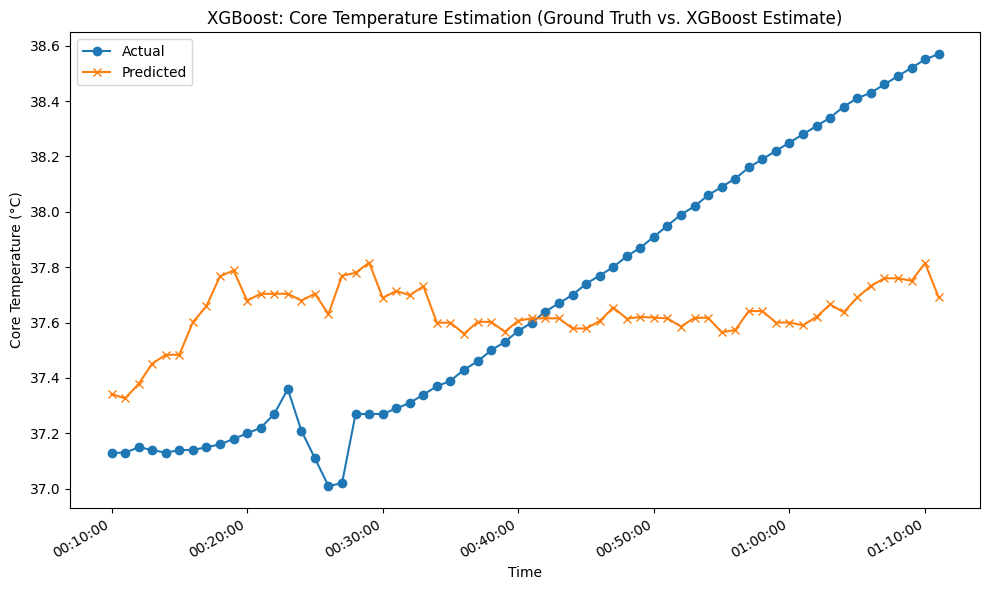

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.dates as mdates



# Separate the prediction data (8, 2, 5) from the main dataset
prediction_data = data[(data['Participant'] == 8) &
                       (data['Condition'] == 2) &
                       (data['Activity code'] == 5)]

# Use the rest of the dataset for training and testing
train_test_data = data[~((data['Participant'] == 8) &
                         (data['Condition'] == 2) &
                         (data['Activity code'] == 5))]

# Define features and target
features = ['HR',
            'SkinTemp hand']
target = 'CoreTemp'

X = train_test_data[features]
y = train_test_data[target]

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost regressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)


print(f"MAE on Test Data: {mae:.2f}")
print(f"RMSE on Test Data: {rmse:.2f}")
# Calculate MAPE
print(f"MAPE on Test Data: {mape:.2f}%")

# Calculate R²
print(f"R² on Test Data: {r2:.2f}")


# Predict on the excluded (8, 2, 5) data
X_pred = prediction_data[features]
y_pred_8_2_5 = model.predict(X_pred)

# Compare predictions with actual values
prediction_data['Predicted_CoreTemp'] = y_pred_8_2_5
print("\nPredictions for (8, 2, 5):")
print(prediction_data[['Time', 'CoreTemp', 'Predicted_CoreTemp']])

import matplotlib.dates as mdates

# Ensure 'Time' is a datetime object
prediction_data['Time'] = pd.to_datetime(prediction_data['Time'], format='%H:%M:%S')  # Adjust format as necessary

plt.figure(figsize=(10, 6))
plt.plot(prediction_data['Time'], prediction_data['CoreTemp'], label='Actual', marker='o')
plt.plot(prediction_data['Time'], prediction_data['Predicted_CoreTemp'], label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Core Temperature (°C)')
plt.title('XGBoost: Core Temperature Estimation (Ground Truth vs. XGBoost Estimate)')
plt.legend()

# Format x-axis for better readability
# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


###LSTM

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0548 - val_loss: 0.0176
Epoch 2/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0157 - val_loss: 0.0176
Epoch 3/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0152 - val_loss: 0.0182
Epoch 4/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0151 - val_loss: 0.0176
Epoch 5/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0155 - val_loss: 0.0177
Epoch 6/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0148 - val_loss: 0.0165
Epoch 7/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0145 - val_loss: 0.0166
Epoch 8/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0140 - val_loss: 0.0165
Epoch 9/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0139 - val_loss: 0.0164
Epoch 10/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0134 - val_loss: 0.0171
Epoch 11/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0131 - val_loss: 0.0162
Epoch 12/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 12

<ipython-input-35-09578acc6b04>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_data['Time'] = pd.to_datetime(prediction_data['Time'], format='%H:%M:%S')  # Adjust format as necessary


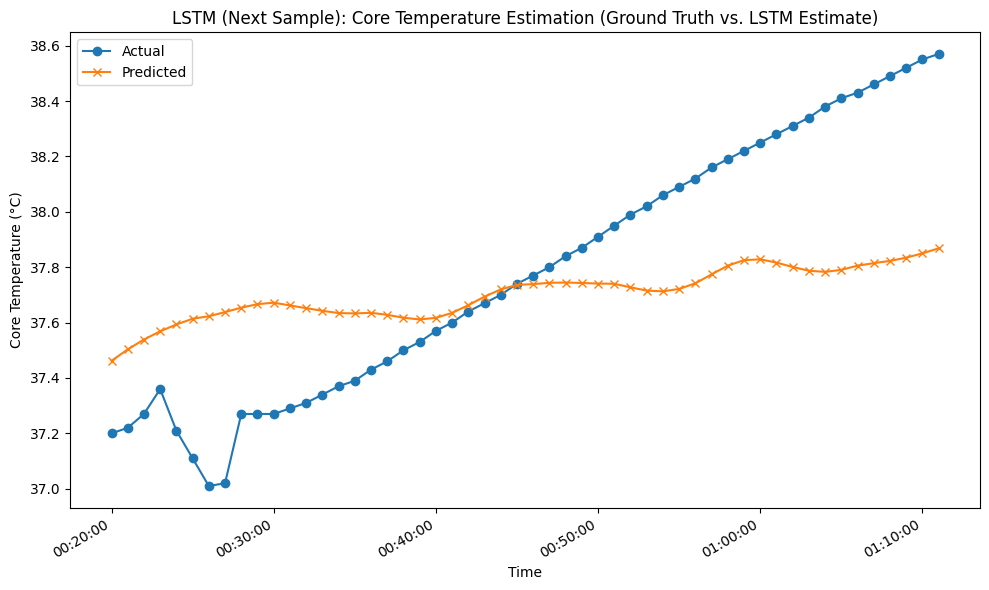

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Prepare the dataset
# Filter for the relevant features and target
features = ['HR', 'SkinTemp hand']
target = 'CoreTemp'

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features + [target]])

# Create a DataFrame for scaled data
data_scaled = pd.DataFrame(data_scaled, columns=features + [target])

# Separate prediction data (8, 2, 5) from the main dataset
prediction_data = data[(data['Participant'] == 8) &
                       (data['Condition'] == 2) &
                       (data['Activity code'] == 5)]
prediction_data_scaled = scaler.transform(prediction_data[features + [target]])

# Use the rest of the dataset for training and testing
train_test_data = data[~((data['Participant'] == 8) &
                         (data['Condition'] == 2) &
                         (data['Activity code'] == 5))]
train_test_data_scaled = scaler.transform(train_test_data[features + [target]])

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, :-1])  # Features
        y.append(data[i+sequence_length, -1])    # Target
    return np.array(X), np.array(y)

sequence_length = 10  # Lookback window
X, y = create_sequences(train_test_data_scaled, sequence_length)

# Split into training and testing sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE on Test Data: {mae:.2f}")
print(f"RMSE on Test Data: {rmse:.2f}")
print(f"MAPE on Test Data: {mape:.2f}%")
print(f"R² on Test Data: {r2:.2f}")

# Predict for (8, 2, 5)
X_pred, _ = create_sequences(prediction_data_scaled, sequence_length)
y_pred_8_2_5 = model.predict(X_pred)

# Rescale predictions back to original scale
y_pred_8_2_5_rescaled = scaler.inverse_transform(
    np.hstack((np.zeros((y_pred_8_2_5.shape[0], len(features))), y_pred_8_2_5))
)[:, -1]
prediction_data_rescaled = scaler.inverse_transform(prediction_data_scaled)[:, -1][sequence_length:]

# Ensure 'Time' is a datetime object
prediction_data['Time'] = pd.to_datetime(prediction_data['Time'], format='%H:%M:%S')  # Adjust format as necessary

# Align Time with rescaled predictions and actual values
time_values = prediction_data['Time'][sequence_length:].reset_index(drop=True)

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(time_values, prediction_data_rescaled, label='Actual', marker='o')
plt.plot(time_values, y_pred_8_2_5_rescaled, label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Core Temperature (°C)')
plt.title('LSTM (Next Sample): Core Temperature Estimation (Ground Truth vs. LSTM Estimate)')
plt.legend()

# Format x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0390 - val_loss: 0.0180
Epoch 2/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0157 - val_loss: 0.0172
Epoch 3/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0153 - val_loss: 0.0178
Epoch 4/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0155 - val_loss: 0.0167
Epoch 5/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0147 - val_loss: 0.0165
Epoch 6/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0143 - val_loss: 0.0159
Epoch 7/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0144 - val_loss: 0.0158
Epoch 8/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0138 - val_loss: 0.0166
Epoch 9/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0135 - val_loss: 0.0163
Epoch 10/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0132 - val_loss: 0.0154
Epoch 11/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0130 - val_loss: 0.0163
Epoch 12/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - los

<ipython-input-32-875c3c956ec5>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_data['Time'] = pd.to_datetime(prediction_data['Time'], format='%H:%M:%S')  # Adjust format as necessary


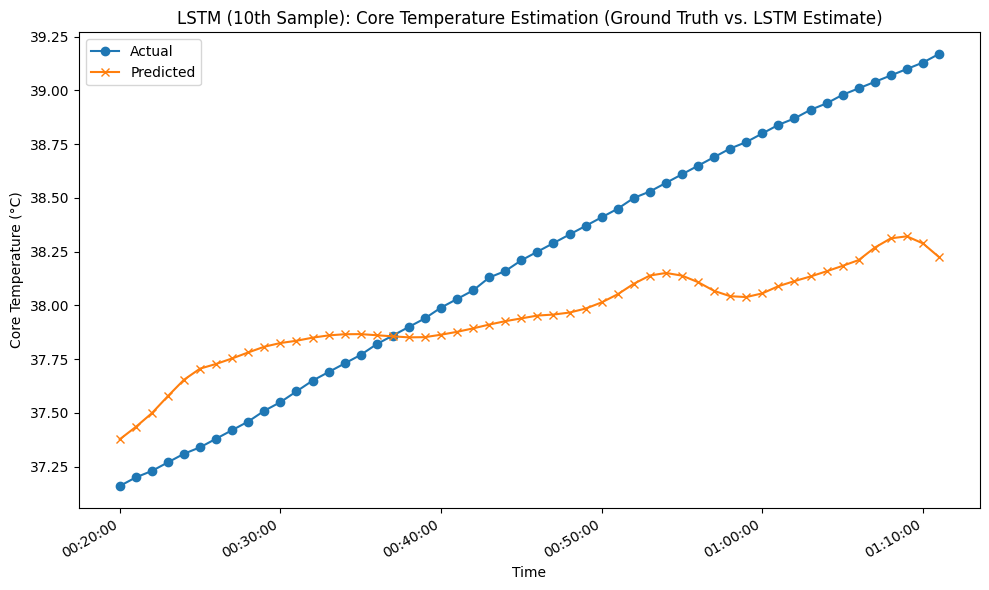

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Prepare the dataset
# Filter for the relevant features and target
features = ['HR', 'SkinTemp hand']
target = 'CoreTemp'

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features + [target]])

# Create a DataFrame for scaled data
data_scaled = pd.DataFrame(data_scaled, columns=features + [target])

# Separate prediction data (8, 2, 5) from the main dataset
prediction_data = data[(data['Participant'] == 6) &
                       (data['Condition'] == 2) &
                       (data['Activity code'] == 5)]
prediction_data_scaled = scaler.transform(prediction_data[features + [target]])

# Use the rest of the dataset for training and testing
train_test_data = data[~((data['Participant'] == 6) &
                         (data['Condition'] == 2) &
                         (data['Activity code'] == 5))]
train_test_data_scaled = scaler.transform(train_test_data[features + [target]])

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, :-1])  # Features
        y.append(data[i+sequence_length, -1])    # Target
    return np.array(X), np.array(y)

sequence_length = 10  # Lookback window
X, y = create_sequences(train_test_data_scaled, sequence_length)

# Split into training and testing sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE on Test Data: {mae:.2f}")
print(f"RMSE on Test Data: {rmse:.2f}")
print(f"MAPE on Test Data: {mape:.2f}%")
print(f"R² on Test Data: {r2:.2f}")

# Predict for (8, 2, 5)
X_pred, _ = create_sequences(prediction_data_scaled, sequence_length)
y_pred_8_2_5 = model.predict(X_pred)

# Rescale predictions back to original scale
y_pred_8_2_5_rescaled = scaler.inverse_transform(
    np.hstack((np.zeros((y_pred_8_2_5.shape[0], len(features))), y_pred_8_2_5))
)[:, -1]
prediction_data_rescaled = scaler.inverse_transform(prediction_data_scaled)[:, -1][sequence_length:]

# Ensure 'Time' is a datetime object
prediction_data['Time'] = pd.to_datetime(prediction_data['Time'], format='%H:%M:%S')  # Adjust format as necessary

# Align Time with rescaled predictions and actual values
time_values = prediction_data['Time'][sequence_length:].reset_index(drop=True)

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(time_values, prediction_data_rescaled, label='Actual', marker='o')
plt.plot(time_values, y_pred_8_2_5_rescaled, label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Core Temperature (°C)')
plt.title('LSTM (10th Sample): Core Temperature Estimation (Ground Truth vs. LSTM Estimate)')
plt.legend()

# Format x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


###nn

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0658 - val_loss: 0.0200
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0182 - val_loss: 0.0212
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0174 - val_loss: 0.0206
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0173 - val_loss: 0.0196
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0172 - val_loss: 0.0196
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0167 - val_loss: 0.0204
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0166 - val_loss: 0.0195
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0167 - val_loss: 0.0199
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0160 - val_loss: 0.0198
Epoch 10/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0160 - val_loss: 0.0191
Epoch 11/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0162 - val_loss: 0.0195
Epoch 12/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.

<ipython-input-18-06e83a7fbb66>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_data['Time'] = pd.to_datetime(prediction_data['Time'], format='%H:%M:%S')  # Adjust format as necessary


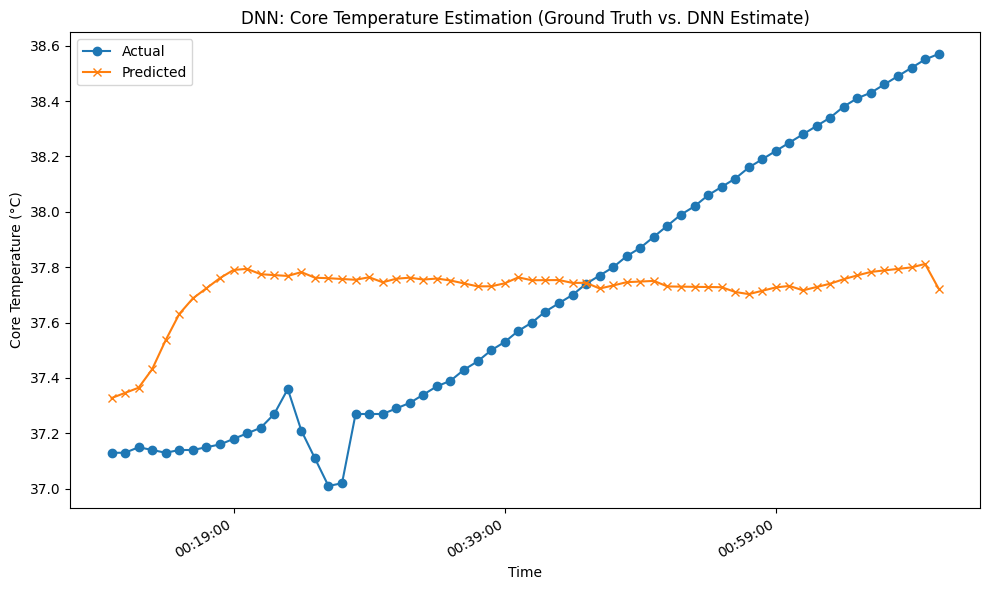

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Prepare the dataset
features = ['HR', 'SkinTemp hand']
target = 'CoreTemp'

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features + [target]])

# Separate prediction data (8, 2, 5) from the main dataset
prediction_data = data[(data['Participant'] == 8) &
                       (data['Condition'] == 2) &
                       (data['Activity code'] == 5)]
prediction_data_scaled = scaler.transform(prediction_data[features + [target]])

# Use the rest of the dataset for training and testing
train_test_data = data[~((data['Participant'] == 8) &
                         (data['Condition'] == 2) &
                         (data['Activity code'] == 5))]
train_test_data_scaled = scaler.transform(train_test_data[features + [target]])

# Split into features (X) and target (y)
X = train_test_data_scaled[:, :-1]
y = train_test_data_scaled[:, -1]

# Split into training and testing sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the neural network
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),  # Regularization
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Output layer for regression
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred.ravel()) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE on Test Data: {mae:.2f}")
print(f"RMSE on Test Data: {rmse:.2f}")
print(f"MAPE on Test Data: {mape:.2f}%")
print(f"R² on Test Data: {r2:.2f}")

# Predict for (8, 2, 5)
X_pred = prediction_data_scaled[:, :-1]
y_pred_8_2_5 = model.predict(X_pred)

# Rescale predictions back to original scale
y_pred_8_2_5_rescaled = scaler.inverse_transform(
    np.hstack((X_pred, y_pred_8_2_5))
)[:, -1]
prediction_data_rescaled = scaler.inverse_transform(prediction_data_scaled)[:, -1]
# Convert Time to string for plotting
# Ensure 'Time' is a datetime object
prediction_data['Time'] = pd.to_datetime(prediction_data['Time'], format='%H:%M:%S')  # Adjust format as necessary

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(prediction_data['Time'], prediction_data_rescaled, label='Actual', marker='o')
plt.plot(prediction_data['Time'], y_pred_8_2_5_rescaled, label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Core Temperature (°C)')
plt.title('DNN: Core Temperature Estimation (Ground Truth vs. DNN Estimate)')
plt.legend()

# Format x-axis for better readability
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=20))  # Adjust interval as needed
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()  # Rotate and auto-align x-axis labels

plt.tight_layout()
plt.show()


<ipython-input-19-ee5a9b4199b0>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Trial', y='Participants', data=df, palette='viridis')


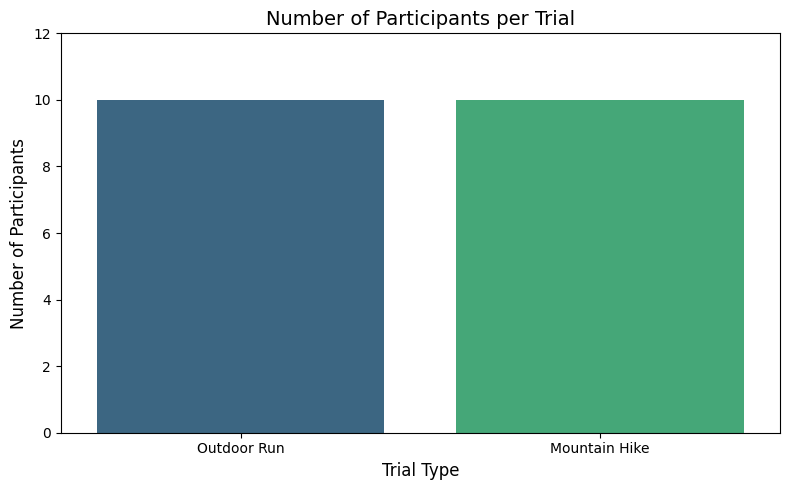

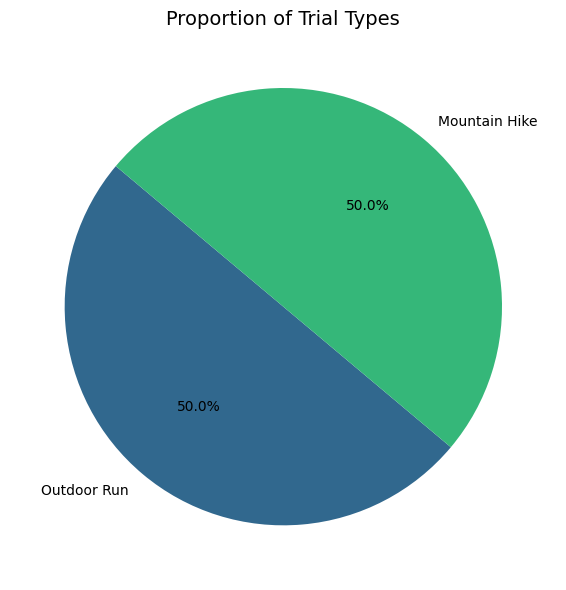

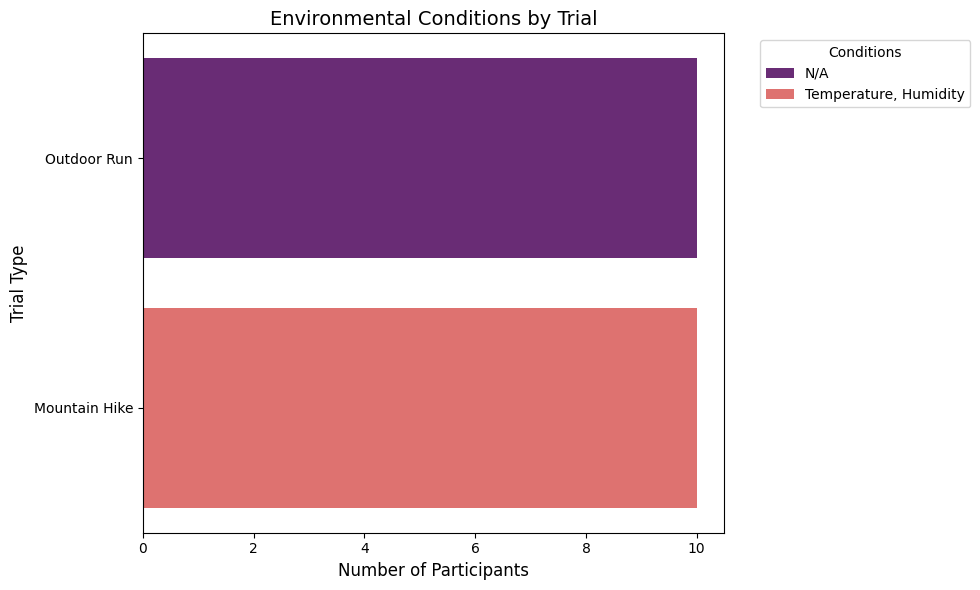

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    'Trial': ['Outdoor Run', 'Mountain Hike'],
    'Participants': [10, 10],
    'Duration (min)': ['>60', 'Variable'],
    'Environmental Conditions': ['N/A', 'Temperature, Humidity']
}

df = pd.DataFrame(data)

# 1. Bar chart for the number of participants per trial
plt.figure(figsize=(8, 5))
sns.barplot(x='Trial', y='Participants', data=df, palette='viridis')
plt.title('Number of Participants per Trial', fontsize=14)
plt.ylabel('Number of Participants', fontsize=12)
plt.xlabel('Trial Type', fontsize=12)
plt.ylim(0, 12)
plt.tight_layout()
plt.show()

# 2. Pie chart for proportion of trial types
plt.figure(figsize=(6, 6))
plt.pie(
    df['Participants'],
    labels=df['Trial'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('viridis', len(df))
)
plt.title('Proportion of Trial Types', fontsize=14)
plt.tight_layout()
plt.show()

# 3. Horizontal bar chart for conditions across trials
plt.figure(figsize=(10, 6))
sns.barplot(
    y='Trial',
    x='Participants',
    data=df,
    hue='Environmental Conditions',
    palette='magma',
    dodge=False
)
plt.title('Environmental Conditions by Trial', fontsize=14)
plt.xlabel('Number of Participants', fontsize=12)
plt.ylabel('Trial Type', fontsize=12)
plt.legend(title='Conditions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0239 - val_loss: 0.0178
Epoch 2/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0157 - val_loss: 0.0188
Epoch 3/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0152 - val_loss: 0.0171
Epoch 4/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0143 - val_loss: 0.0162
Epoch 5/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0134 - val_loss: 0.0167
Epoch 6/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0135 - val_loss: 0.0161
Epoch 7/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0136 - val_loss: 0.0157
Epoch 8/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0127 - val_loss: 0.0157
Epoch 9/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0120 - val_loss: 0.0159
Epoch 10/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0121 - val_loss: 0.0158
Epoch 11/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0116 - val_loss: 0.0158
Epoch 12/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 4s 9m

<ipython-input-36-0cc602dd0ae0>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_data['Time'] = pd.to_datetime(prediction_data['Time'], format='%H:%M:%S')  # Adjust format as necessary


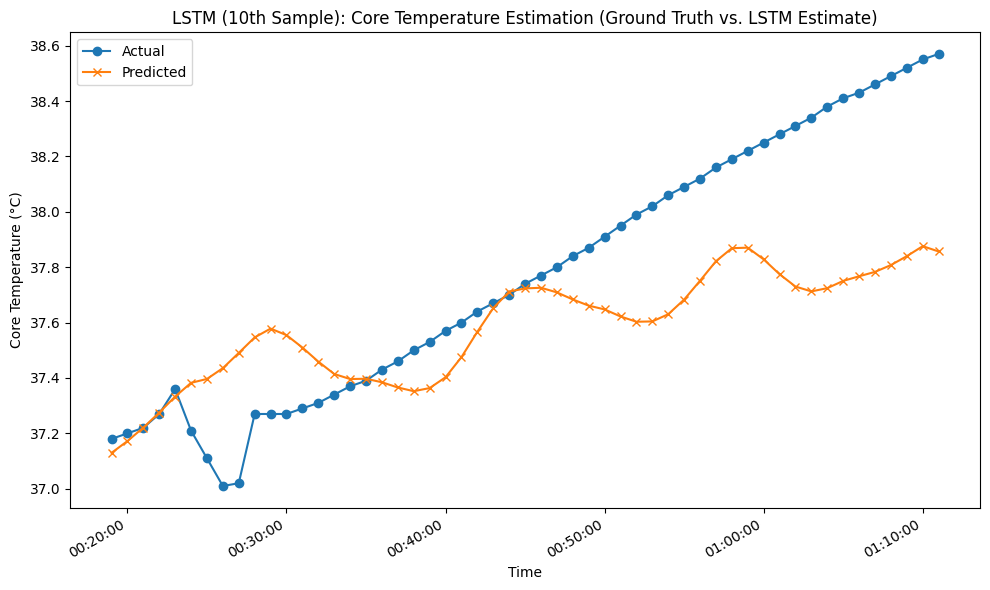

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Prepare the dataset
# Filter for the relevant features and target
features = ['HR', 'SkinTemp hand']
target = 'CoreTemp'

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features + [target]])

# Create a DataFrame for scaled data
data_scaled = pd.DataFrame(data_scaled, columns=features + [target])

# Separate prediction data (8, 2, 5) from the main dataset
prediction_data = data[(data['Participant'] == 8) &
                       (data['Condition'] == 2) &
                       (data['Activity code'] == 5)]
prediction_data_scaled = scaler.transform(prediction_data[features + [target]])

# Use the rest of the dataset for training and testing
train_test_data = data[~((data['Participant'] == 8) &
                         (data['Condition'] == 2) &
                         (data['Activity code'] == 5))]
train_test_data_scaled = scaler.transform(train_test_data[features + [target]])

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length + 1):  # Adjust to predict the 10th sample
        X.append(data[i:i+sequence_length, :-1])  # Features
        y.append(data[i+sequence_length-1, -1])   # Target is 10th sample
    return np.array(X), np.array(y)

sequence_length = 10  # Lookback window
X, y = create_sequences(train_test_data_scaled, sequence_length)

# Split into training and testing sets (80-20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE on Test Data: {mae:.2f}")
print(f"RMSE on Test Data: {rmse:.2f}")
print(f"MAPE on Test Data: {mape:.2f}%")
print(f"R² on Test Data: {r2:.2f}")

# Predict for (8, 2, 5)
X_pred, _ = create_sequences(prediction_data_scaled, sequence_length)
y_pred_8_2_5 = model.predict(X_pred)

# Rescale predictions back to original scale
y_pred_8_2_5_rescaled = scaler.inverse_transform(
    np.hstack((np.zeros((y_pred_8_2_5.shape[0], len(features))), y_pred_8_2_5))
)[:, -1]
prediction_data_rescaled = scaler.inverse_transform(prediction_data_scaled)[:, -1][sequence_length-1:]

# Ensure 'Time' is a datetime object
prediction_data['Time'] = pd.to_datetime(prediction_data['Time'], format='%H:%M:%S')  # Adjust format as necessary

# Align Time with rescaled predictions and actual values
time_values = prediction_data['Time'][sequence_length-1:].reset_index(drop=True)

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(time_values, prediction_data_rescaled, label='Actual', marker='o')
plt.plot(time_values, y_pred_8_2_5_rescaled, label='Predicted', marker='x')
plt.xlabel('Time')
plt.ylabel('Core Temperature (°C)')
plt.title('LSTM (10th Sample): Core Temperature Estimation (Ground Truth vs. LSTM Estimate)')
plt.legend()

# Format x-axis for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()